In [ ]:
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import sqlite3
import seaborn as sns

# Задачи:
- 1) Обучить модель(на выбор), для предсказания цены квартиры в г.Магнитогорск;
- 2) Сделать для модели Rest api, при подачи параметров в js, модель должна выдавать цену квартиры.

### Итог:
##### 1. При анализе данных было установленно:
- Самый дорогостоящий район это Орджоникидзевский, самый дешовый Орджоникидзевский (левый берег);
- Самое дорогостоящие риэлтерское агенство это "Агентство Недвижимости Ключи", самое дешовое;
- Самые дорогие квартиры продаются на 4 этаже, самые дешовые на 1-ом;
##### 2. Обучение модели и Rest Api:
- Прежде чем перейти к обучению было установлено, что данные подчиняются нормальному закону распределения;
- Так же было установленно, что данные коррелированны. Это подходило нам по условию, т.к мы работаем с линейной задачей;
- Первым решением было принято, обучить модель линейной регрессии и проверить её качество относительно target, по метрике MSE(СКО), которая составила MSE = 1865900.46;
- После полученного, первого результата приняли решение взять первую модель за Besline и обучить новый алгоритм, выбор пал на CatBoost;
- Резуьтаты получились лучше, чем в первый раз (MSE(СКО) = 834098.4), было решено использовать CatBoost для предсказания квартир;
- Сервис Rest Api выполнил свою задачу, при общание к локальному хосту с параметрами квартиры, обратно мы получаем её цену.

### 1. Выгрузим данные по квартирам используя url

In [3]:
url = "http://citystar.ru/detal.htm?d=43&nm="
r = requests.get(url)
bs_page = BeautifulSoup(r.content)

In [4]:
bs_table = bs_page.find('table', attrs={'class': 'tbrd'})
bs_str = bs_table.find_all('tr', attrs={'class': 'tbb'})
# table = [i.find_all('td', attrs={'class': ['ttx','tcb']}) for i in bs_str]
cleaned_table = [[j.text.strip() for j in i.find_all('td', attrs={'class': ['ttx','tcb']})] for i in bs_str]
cleaned_table = list(filter(None, cleaned_table))
# cleaned_table

### 2. Сделаем предобработку данных

In [5]:
df = pd.DataFrame(cleaned_table, columns=['Null','date','title','area','adress','floor','o_m2','j_m2','k_m2','komment','price','phone','agency','E-mail'])
df['area'] = df['area'].replace('Ордженикидзевский', 'Орджоникидзевский')
df['area'] = df['area'].replace('', None)
df['area'] = df['area'].replace('ленинский', 'Ленинский')
df['agency'] = df['agency'].replace('', None)
df['o_m2'] = df['o_m2'].astype('float')
df['j_m2'] = df['j_m2'].astype('float')
df['k_m2'] = df['k_m2'].astype('float')
df['price'] = df['price'].astype('int')
df['price'] = df['price'].astype('int')
df[['floor', 'sum_floor']] = df['floor']. str.split('/', 2 , expand= True ).astype('int')
df1 = df[['title','area','adress','floor','sum_floor','o_m2','j_m2','k_m2','price','agency']]
df1.head()

,title,area,adress,floor,sum_floor,o_m2,j_m2,k_m2,price,agency
0,Двухкомнатная брежневка,Правобережный,Советская 137,1,5,44.0,28.0,6.0,3250,None
1,Однокомнатная нестандартная,Орджоникидзевский,Карла Маркса 224,5,16,41.1,20.0,12.0,3500,None
2,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5,16,105.0,75.0,14.0,7700,None
3,Двухкомнатная старой планировки,Ленинский,Московская 37,1,3,48.0,33.0,8.0,2900,None
4,Трехкомнатная свердловский вариант,Орджоникидзевский,Ворошилова 13/1,4,13,65.0,43.0,10.0,4450,None


### 3. Проведём предворительный анализ данных EDA

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      100 non-null    object 
 1   area       63 non-null     object 
 2   adress     100 non-null    object 
 3   floor      100 non-null    int32  
 4   sum_floor  100 non-null    int32  
 5   o_m2       100 non-null    float64
 6   j_m2       100 non-null    float64
 7   k_m2       100 non-null    float64
 8   price      100 non-null    int32  
 9   agency     78 non-null     object 
dtypes: float64(3), int32(3), object(4)
memory usage: 6.8+ KB


#### 3.1 Посмотрим на кол-во пропусков в данных

agency_Nan: 22, area_Nan: 37


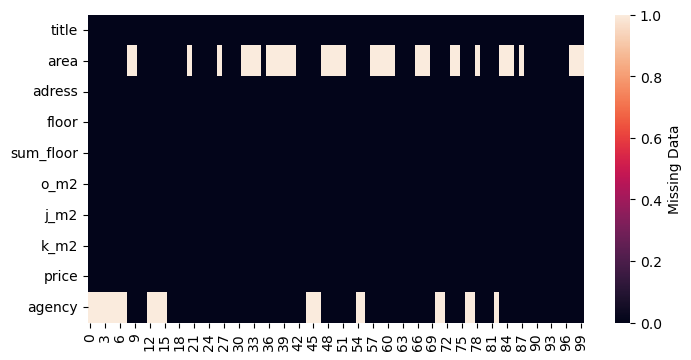

In [9]:
#Поиск пропусков с помощью графика
plt.figure(figsize=(8,4))
sns.heatmap(df1.isna().transpose(),
           cbar_kws={'label':'Missing Data'})
a= df1['agency'].isna().sum()
b= df1['area'].isna().sum()
print(f'agency_Nan: {a}'+','+' '+ f'area_Nan: {b}')

- Видим, что пропуски имеются только в коллонках area и agency

#### 3.2 Проведём анализ цены в разбивке по району, агенству, этажу

In [11]:
df1.groupby('area')['price'].agg(['min','max','mean']).round(2)

,min,max,mean
area,,,
Ленинский,1600,6400,4524.29
Ленинский (Левый берег),3500,3500,3500.00
Орджоникидзевский,2406,8200,4533.10
Орджоникидзевский (левый берег),2000,2350,2216.67
Правобережный,1790,9055,3878.21


- Самый дорогой район для покупки квартиры в городе это "Орджоникидзевский"
- Самый дешовый район это "Орджоникидзевский (левый берег)"

In [12]:
df1.groupby('agency')['price'].agg(['min','max','mean']).head().round(2)

,min,max,mean
agency,,,
"""Шанс""",2900,5300,4166.67
START,2970,2970,2970.00
АН «Монтера Курорт»,2500,4300,3475.00
Агентство Недвижимости Ключи,2570,8200,5586.67
Визит,1790,4590,3376.67


- Самый дорогой чек за оказываемую реэлтерскую услугу у организации "Агентство Недвижимости Ключи";
- Самый минимальный у компании "Визит";

In [13]:
df1.groupby('floor')['price'].agg(['min','max','mean']).head().round(2)

,min,max,mean
floor,,,
1,2,5100,3026.60
2,1600,6300,3582.86
3,2000,6800,3863.85
4,2300,8000,4485.09
5,1950,7700,3893.33


- Квартира на 4 этаже стоит дороже всего;
- Квартитра на 1 этаже самая дешовая;

#### 3.3 Посмотрим на плотность распределения цен

[2, 500, 1600, 1700, 1790, 1800, 1850, 1950, 2000, 2000, 2050, 2150, 2190, 2300, 2350, 2400, 2400, 2406, 2450, 2450, 2500, 2500, 2500, 2550, 2570, 2600, 2700, 2700, 2750, 2750, 2800, 2800, 2850, 2900, 2900, 2900, 2900, 2950, 2970, 3050, 3150, 3250, 3300, 3350, 3400, 3400, 3400, 3400, 3400, 3490, 3500, 3500, 3600, 3600, 3700, 3790, 3800, 3800, 4000, 4150, 4150, 4190, 4200, 4250, 4300, 4300, 4300, 4300, 4300, 4300, 4400, 4450, 4450, 4490, 4590, 4890, 4990, 5000, 5100, 5200, 5200, 5300, 5490, 5600, 5600, 5990, 6000, 6050, 6200, 6200, 6300, 6300, 6300, 6400, 6800, 7700, 8000, 8000, 8200, 9055]
median - 3495.0
mean - 3852.93
mode -4300


<Figure size 800x400 with 0 Axes>

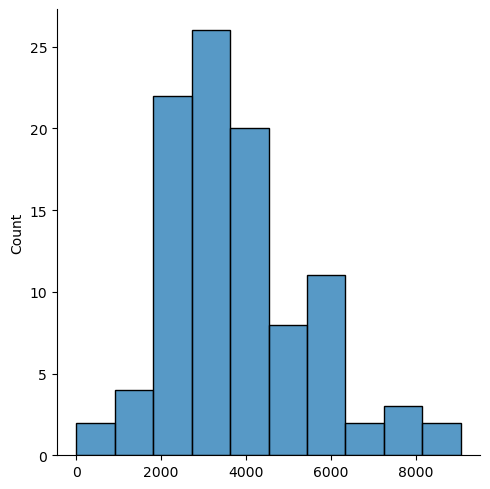

In [15]:
#Проверка распределения target
from scipy import stats
plt.figure(figsize=(8,4))
x =np.array(df1['price'])
print(sorted(x))
print(f'median - {np.quantile(x, q = 0.5)}\nmean - {np.mean(x)}\nmode -{stats.mode(x)[0][0]}' )
sns.displot(x, bins=10);

Text(0.5, 0.98, 'Describution of price')

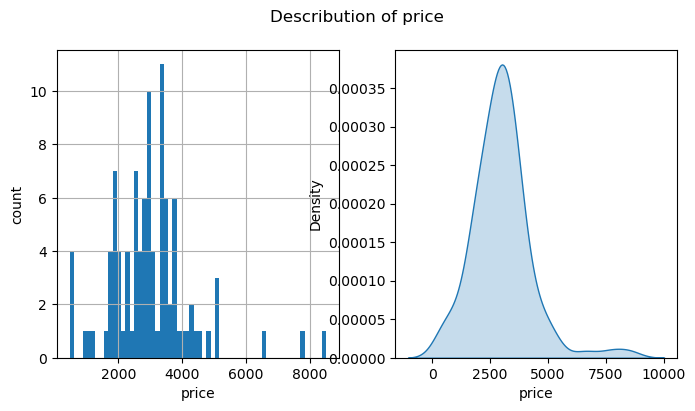

In [61]:
plt.figure(figsize=(8,4))

plt.subplot(121)
df1['price'].hist(density=False, bins=60)
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(df1['price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Describution of price')

Mean: 2995.57, Median: 2900.0, Mode: 1850
p-value:  2.1075868517073104e-06


C:\Users\roman\AppData\Local\Temp\ipykernel_1396\1293931371.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot([price_mean_1] * 100000 , np.abs(np.log(y)), label='mean',linestyle=':', linewidth=4)
C:\Users\roman\AppData\Local\Temp\ipykernel_1396\1293931371.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot([price_median_1] * 100000, np.abs(np.log(y)), label='median', linestyle='--',linewidth=4)
C:\Users\roman\AppData\Local\Temp\ipykernel_1396\1293931371.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot([price_mode_1] * 100000, np.abs(np.log(y)), label='mode', linestyle='-.', linewidth=4)


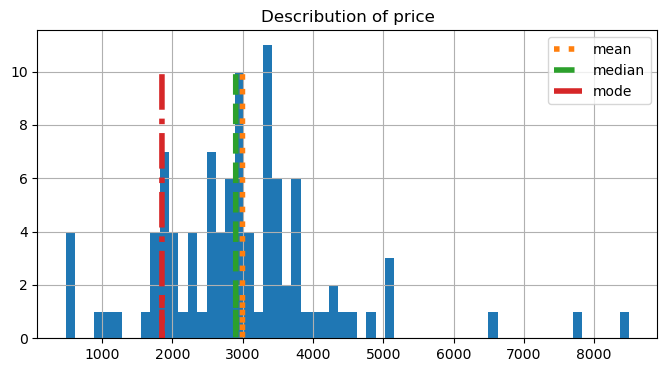

In [62]:
plt.figure(figsize = (8, 4))
df1['price'].hist(density=False, bins=60)
# Истенные оценки
price_mean_1 =  round(df1['price'].mean(), 2)
price_median_1 =  df1['price'].median()
price_mode_1 =  df1['price'].mode()[0]
print(f'Mean: {price_mean_1}, Median: {price_median_1}, Mode: {price_mode_1}')

y = np.linspace(0, 5, 100000)
plt.plot([price_mean_1] * 100000 , np.abs(np.log(y)), label='mean',linestyle=':', linewidth=4)
plt.plot([price_median_1] * 100000, np.abs(np.log(y)), label='median', linestyle='--',linewidth=4)
plt.plot([price_mode_1] * 100000, np.abs(np.log(y)), label='mode', linestyle='-.', linewidth=4)

res = stats.shapiro((df1['price']))
print('p-value: ', res[1])

plt.title('Describution of price')
plt.legend()
plt.show()

- Данные разпределены относительно нормально, есть небольшое кол-во выбросов, наиболее повторяющиеся значение это 4300;

#### 3.4 Посмотрим на кол-во выбросов в каждом параметре

<AxesSubplot:>

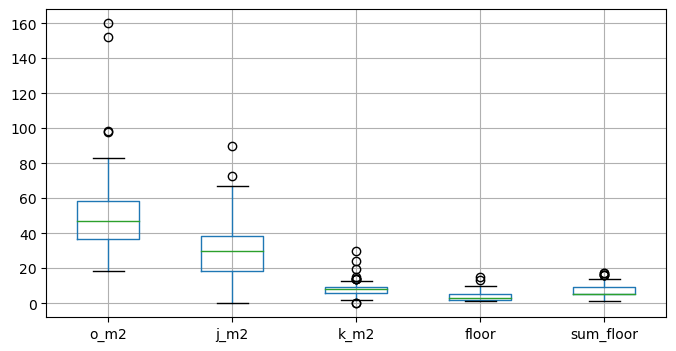

In [63]:
fig, ax = plt.subplots(figsize = (8,4))
df1.boxplot(['o_m2', 'j_m2', 'k_m2','floor','sum_floor'])

- 'o_m2', 'j_m2' - самые выбросные параметры;

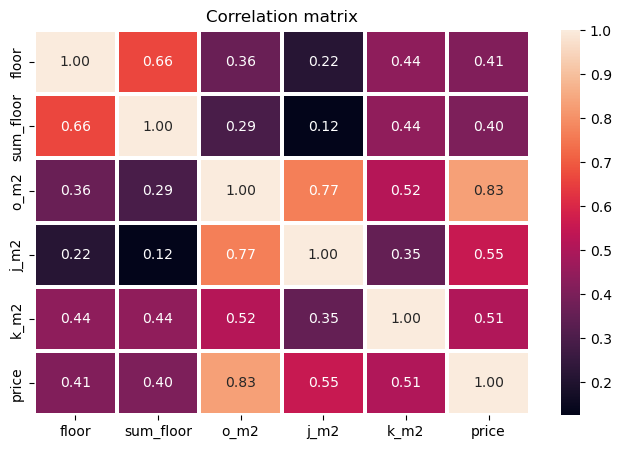

In [64]:
corr = df1.corr()

f, ax = plt.subplots(figsize =(8,5))
sns.heatmap(corr, annot = True, linewidths=1.5, fmt ='.2f', ax=ax)
plt.title('Correlation matrix')
plt.show()

- В первый раз после отчистки выбросов корреляция приемущественно стремилась к 0;
- Достаточно сильная корреляция относительно нашего target(price);
- Т.к у нас линейная зависимость, попробуем падать все имеющиеся параметры кв. на вход модели, без предварительных backtesting, далее отсеем параметры, которые модель сочтёт не нужными.

### 4. Выгружаем выборку в базу данных

In [16]:
# Выделяем выборку
df= df1[['area','price','o_m2', 'j_m2', 'k_m2','floor','sum_floor']]
df.head()

,area,price,o_m2,j_m2,k_m2,floor,sum_floor
0,Правобережный,3250,44.0,28.0,6.0,1,5
1,Орджоникидзевский,3500,41.1,20.0,12.0,5,16
2,Орджоникидзевский,7700,105.0,75.0,14.0,5,16
3,Ленинский,2900,48.0,33.0,8.0,1,3
4,Орджоникидзевский,4450,65.0,43.0,10.0,4,13


In [17]:
#Создаём базу данных
with sqlite3.connect('E:/Работа/Белка Диджитал/database.db') as db:
    cursor = db.cursor()
    #query = """CREATE TABLE IF NOT EXISTS apartments(title TEXT, area TEXT, adress TEXT, floor TEXT, o_m2 REAL, j_m2 REAL, k_m2 REAL, price INTEGER, agency TEXT)"""
    query = """CREATE TABLE IF NOT EXISTS apartments (area TEXT, price INTEGER, o_m2 REAL,j_m2 REAL, k_m2 REAL, floor INTEGER,sum_floor INTEGER )"""
    cursor.execute(query)

In [18]:
#Подгружаем данные в базу
con = sqlite3.connect('database.db')
df.to_sql('apartments', con=con, if_exists='append', index=False)

100

### 5. Реализуем модель для предсказания цены квартиры в г.Магнитогорск

- Т.к задача по своей формулировки является линейной и большой показатель коэф.корреялции Пирсона, мы реализуем модель линейной регрессии.

#### 5.1 Проведём оценку статистик параметров подав их в модель

In [19]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Выгрузка данных из БД:
con = sqlite3.connect('database.db')
data = pd.read_sql("SELECT * FROM apartments", con)

# Подготовка данных для модели:
x1 = data['o_m2'].values
x2 =  data['j_m2'].values
x3 = data['k_m2'].values
x4 = data['floor'].values
x5 = data['sum_floor'].values

X = np.array([x1,x2,x3,x4,x5]).T
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Обучение модели:
linreg_sm = sm.OLS(y_train, sm.add_constant(X_train, prepend=True))
linreg_sm_model = linreg_sm.fit()
linreg_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     40.43
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           2.08e-26
Time:                        14:44:34   Log-Likelihood:                -1339.2
No. Observations:                 160   AIC:                             2690.
Df Residuals:                     154   BIC:                             2709.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        362.5389    254.052      1.427      0.156    -139.338     864.416
x1            35.8609      7.390      4.853      0.000      21.262      50.460
x2            11.1908      8.660      1.292      0.198      -5.917      28.298
x3            33.0059     32.666      1.010      0.314     -31.525      97.537
x4            27.1045     39.104      0.693      0.489     -50.144     104.353
x5            69.2045     29.946      2.311      0.022      10.047     128.362
==============================================================================
Omnibus:                       27.782   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.611
Skew:                          -0.556   Prob(JB):                     2.34e-22
Kurtosis:                       6.702   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- По полученной статистики p_value понимаем, что в итоговой модели мы можем использовать только два параметра: o_m2, sum_floor;

In [37]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Выгрузка данных из БД:
con = sqlite3.connect('database.db')
data = pd.read_sql("SELECT * FROM apartments", con)

# Подготовка данных для модели:
x1 = data['o_m2'].values
x5 = data['sum_floor'].values

X = np.array([x1,x5]).T
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Обучение модели:
linreg_sm = sm.OLS(y_train, sm.add_constant(X_train, prepend=True))
linreg_sm_model = linreg_sm.fit()
linreg_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     43.54
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           9.03e-16
Time:                        14:57:12   Log-Likelihood:                -1371.9
No. Observations:                 160   AIC:                             2750.
Df Residuals:                     157   BIC:                             2759.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1161.3863    274.044      4.238      0.000     620.097    1702.676
x1            25.0472      3.226      7.764      0.000      18.675      31.419
x2           131.5428     27.660      4.756      0.000      76.908     186.178
==============================================================================
Omnibus:                       33.863   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.295
Skew:                          -0.421   Prob(JB):                     8.95e-54
Kurtosis:                       8.995   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Подтверждаем гипотезу о том, что в модель должны войти o_m2, sum_floor, итговая статистика p_value ниже 0.05;

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

x1 = data['o_m2'].values
x5 = data['sum_floor'].values

X = np.array([x1,x5]).T
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Обучение модели:
model = LinearRegression().fit(X_train,y_train)
coef_sklearn = model.coef_.T

# Прогноз модели:
y_out = model.predict(X_test)
y_out = y_out.reshape(-1,1)

# Проверка качества модели: 
r2_score = r2_score(y_test, y_out)
SKO = mean_squared_error(y_test, y_out)
AE = mean_absolute_error(y_test, y_out)

# Выход оценок модели:
df4 = data[['o_m2', 'sum_floor']]
print(pd.DataFrame(coef_sklearn.round(2), index = df4.columns, columns = ['coef']))
print(f'R^2: {r2_score.round(2)}, СКО: {SKO.round(2)}, AE: {AE.round(2)}')


             coef
o_m2        23.14
sum_floor  101.24
R^2: 0.42, СКО: 1865900.46, AO: 1018.88


- По полученным результатам стало ясно, что модель линейной регрессии не совсем точно предсказывает наш target;
- Метрики R^2 и MSE это подтверждают;
- В защиту модели стоит отметить, что при работе с квадратами обычно ошибка является большой, в то время как абсолютная ошибка показывает нам, что мы ошибкаемя только на 1018.88;
- Обозначим эту модель, как Besline и обучим следующий алгоритм.

#### 5.2 Обучение нового алгоритма

- Для нового алгоритма используем CatBoost, проверим на сколько снизится СКО(MSE) 

In [45]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1000,  # Количество деревьев
                          depth=6,  # Глубина деревьев
                          learning_rate=0.1,  # Скорость обучения
                          loss_function='RMSE',  # Функция потерь для регрессии
                          verbose=200)  # Отображение процесса обучения
# Обучение модели
model.fit(X_train, y_train, eval_set=(X_test, y_test))
# Прогноз модели:
y_pred = model.predict(X_test)

# Расчет среднеквадратичной ошибки и Абслотной ошибкаки(MSE, AE)
mse = mean_squared_error(y_test, y_pred)
AE = mean_absolute_error(y_test, y_out)

print(f'СКО: {round(mse,2)}, AE: {round(AO,2)}')

0:	learn: 1382.6482083	test: 1812.0156728	best: 1812.0156728 (0)	total: 767us	remaining: 767ms
200:	learn: 406.8360047	test: 984.1142551	best: 913.2898770 (61)	total: 126ms	remaining: 500ms
400:	learn: 288.5724700	test: 1054.8012392	best: 913.2898770 (61)	total: 254ms	remaining: 379ms
600:	learn: 231.6971943	test: 1088.8009185	best: 913.2898770 (61)	total: 383ms	remaining: 254ms
800:	learn: 204.6660385	test: 1110.9833786	best: 913.2898770 (61)	total: 515ms	remaining: 128ms
999:	learn: 189.3695029	test: 1126.5462654	best: 913.2898770 (61)	total: 641ms	remaining: 0us

bestTest = 913.289877
bestIteration = 61

Shrink model to first 62 iterations.
СКО: 834098.4, AO: 1018.88


- Отлично, видим что ошибка снизилась в разы! Используем теперь данный алгоритм, для предсказания цен квартир.

In [46]:
# Сохраним обученную модль:
dump(model, 'model.h5') 

['model.h5']

### 5. Создаём REST API

In [47]:
from flask import Flask, jsonify, request 
from flask_restful import Api, Resource
from joblib import dump, load

app  = Flask(__name__)
api = Api(app)

model = load('model.h5')

class MakePrediction(Resource):
    @staticmethod
    def post():
        posted_data = request.get_json()
        o_m2 = posted_data['o_m2']
        sum_floor = posted_data['sum_floor']
        prediction = model.predict([[o_m2,sum_floor]])[0]
        return jsonify({
            'Prediction': prediction
        })
   
api.add_resource(MakePrediction, '/Prediction')
api.init_app(app)

if __name__ == '__main__':
    app.run(port=3000, host="127.0.0.1") #debug=False, 127.0.0.1

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:3000/ (Press CTRL+C to quit)


[2023-10-02 17:15:24,517] ERROR in app: Exception on /Prediction [POST]
Traceback (most recent call last):
  File "c:\Users\roman\Anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\roman\Anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "c:\Users\roman\Anaconda3\lib\site-packages\flask_restful\__init__.py", line 467, in wrapper
    resp = resource(*args, **kwargs)
  File "c:\Users\roman\Anaconda3\lib\site-packages\flask\views.py", line 89, in view
    return self.dispatch_request(*args, **kwargs)
  File "c:\Users\roman\Anaconda3\lib\site-packages\flask_restful\__init__.py", line 582, in dispatch_request
    resp = meth(*args, **kwargs)
  File "C:\Users\roman\AppData\Local\Temp\ipykernel_14160\1660056699.py", line 14, in post
    o_m2 = posted_data['o_m2']
TypeError: 'NoneType' object is not subscriptable
127.0.0.1 - 

- Успех, модель выдаёт нам искомый результат при обращении через Api!